# Prediction of Diabetes based on given attribute using PIMA Diabetes dataset

In [9]:
import numpy as np   
import matplotlib as plt
import pandas as pd
import seaborn as sns
#models
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from keras.models import Sequential
from keras.layers import Dense
#Evaluation
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix, classification_report,plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve,auc
#for warning 
from warnings import filterwarnings
filterwarnings("ignore")


## Function definations 

In [28]:
def violin_plot(nrow=4,ncol=2): 
    """
    funtion to plot violin plot for all attributes
    
    input : optional input for number of column and rows for subplot by default value are 2,4 respectively
    
    output : violin plot for all attribute of dataframe 
    
    return : none
    """
    fig = plt.figure(figsize=(14,25))
    fig.tight_layout(pad=3.0)
    nrow,ncol,index=4,2,1    
    for attribute in attributes:
        plt.subplot(nrow, ncol, index)
        plt.title(attribute)
        sns.violinplot(x="Outcome", y=attribute, data=data)
        index+=1
    plt.show()
    
##############################################################################################################
        
def plot_auc(fpr,tpr,auc_model):
    """
    This function pots the ROC curve with help of False positive rate
    and True positive rate and auc object
    
    input : false positive rate, ture positive rate,auc of model
    
    output : ROC plot 
    
    return : None
    """
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc_model))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
 
#############################################################################################################

# calculation of median for each attribute for both possible outcome  
def median_target(attribute):
    """
    This function replaces the Nan of given attribute with 
    median when grouped by Outcome into the global variable 
    data("dataframe")
    
    input : attribute 
    
    output : column of that attibute is modified 
    
    return : none
    """
    temp = data[data[attribute].notnull()]# assigning non null value to temp 
    temp = temp[[attribute, 'Outcome']].groupby(['Outcome'])[[attribute]].mean().reset_index() #calculate mean for a attribute with either 0 or      1 outcome 
    mean_op_0=temp[attribute][0]
    mean_op_1=temp[attribute][1]
    data.loc[(data['Outcome'] == 0 ) & (data[attribute].isnull()), attribute] = mean_op_0 #assigning mean to null values 
    data.loc[(data['Outcome'] == 1 ) & (data[attribute].isnull()), attribute] = mean_op_1
    
##############################################################################################################

def median_target_all():
    # calling meadian_target for each attribute
    for attribute in attributes:
            median_target(attribute) 

##############################################################################################################
        
def outliers_removal():
    """
    This function removes outlier of the global variable data(dataframe)
    using IQR method 
    """
    #loop for replacing outlier of all attribute with Nan value 
    for attribute in attributes:
        q1 = data[attribute].quantile(0.25)
        q3 = data[attribute].quantile(0.75)
        iqr = q3 - q1
        fence_low = q1 - 1.5 * iqr 
        fence_high = q3 + 1.5 * iqr
        data.loc[(data[attribute] < fence_low) | (data[attribute] > fence_high),attribute]=np.nan

##############################################################################################################
        
def z_score(df):
    """Function for apply z score standardization
    
       Input: dataframe to be standardized
       
       output :standardized dataframe 
    """
    df_std = df.copy()
    for column in df_std.columns:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()     
    return df_std



In [29]:
# loading of PIMA dataset 
data = pd.read_csv("diabetes.csv")
# assigning independent variable to attributes 
attributes = data.drop("Outcome",axis=1).columns

### Attributes
    1. Pregnancies: Number of times pregnant
    2. Glucose : Plasma glucose concentration a 2 hours in an oral glucose tolerance test
    3. BloodPressure : Diastolic blood pressure (mm Hg)
    4. SkinThickness : Triceps skin fold thickness (mm)
    5. Insulin : 2-Hour serum insulin (mu U/ml)
    6. BMI : Body mass index (weight in kg/(height in m)^2)
    7. DiabetesPedigreeFunction : It provided some data on diabetes mellitus history in relatives and the genetic           relationship of those relatives to the patient.
    8. Age : Age (years)
    9. Outcome : Class variable (0 or 1) 268 of 768 are 1, the others are 0

## EDA

In [30]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [52]:
data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 54.1 KB


In [32]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


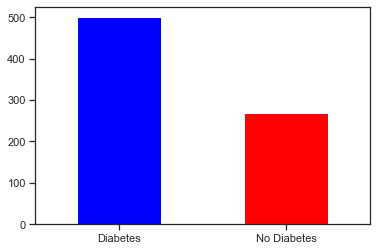

In [33]:
ax=data["Outcome"].value_counts().plot(kind="bar",color=["blue","red"])
ax.set_xticklabels(['Diabetes','No Diabetes'],rotation=0);

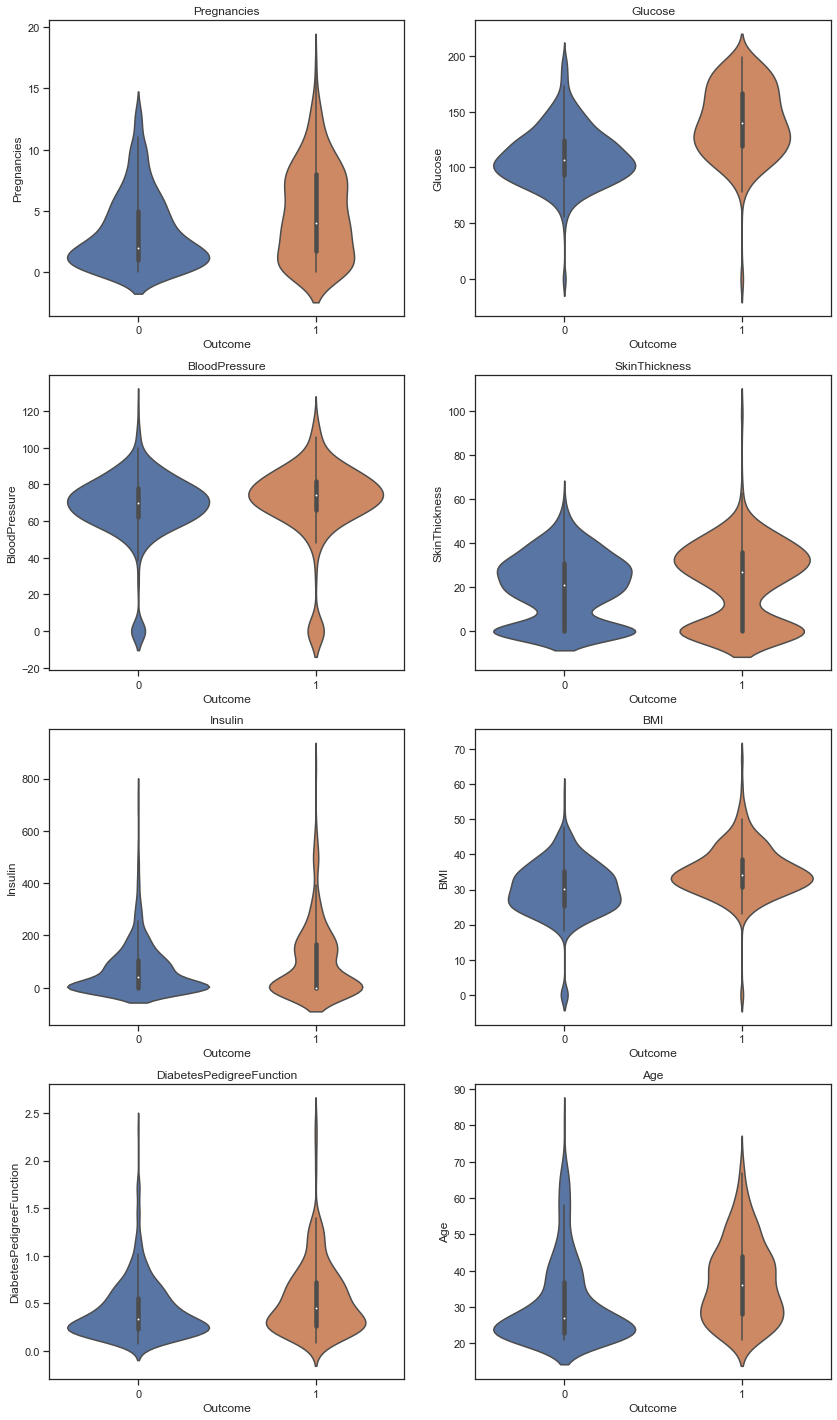

In [34]:
violin_plot()

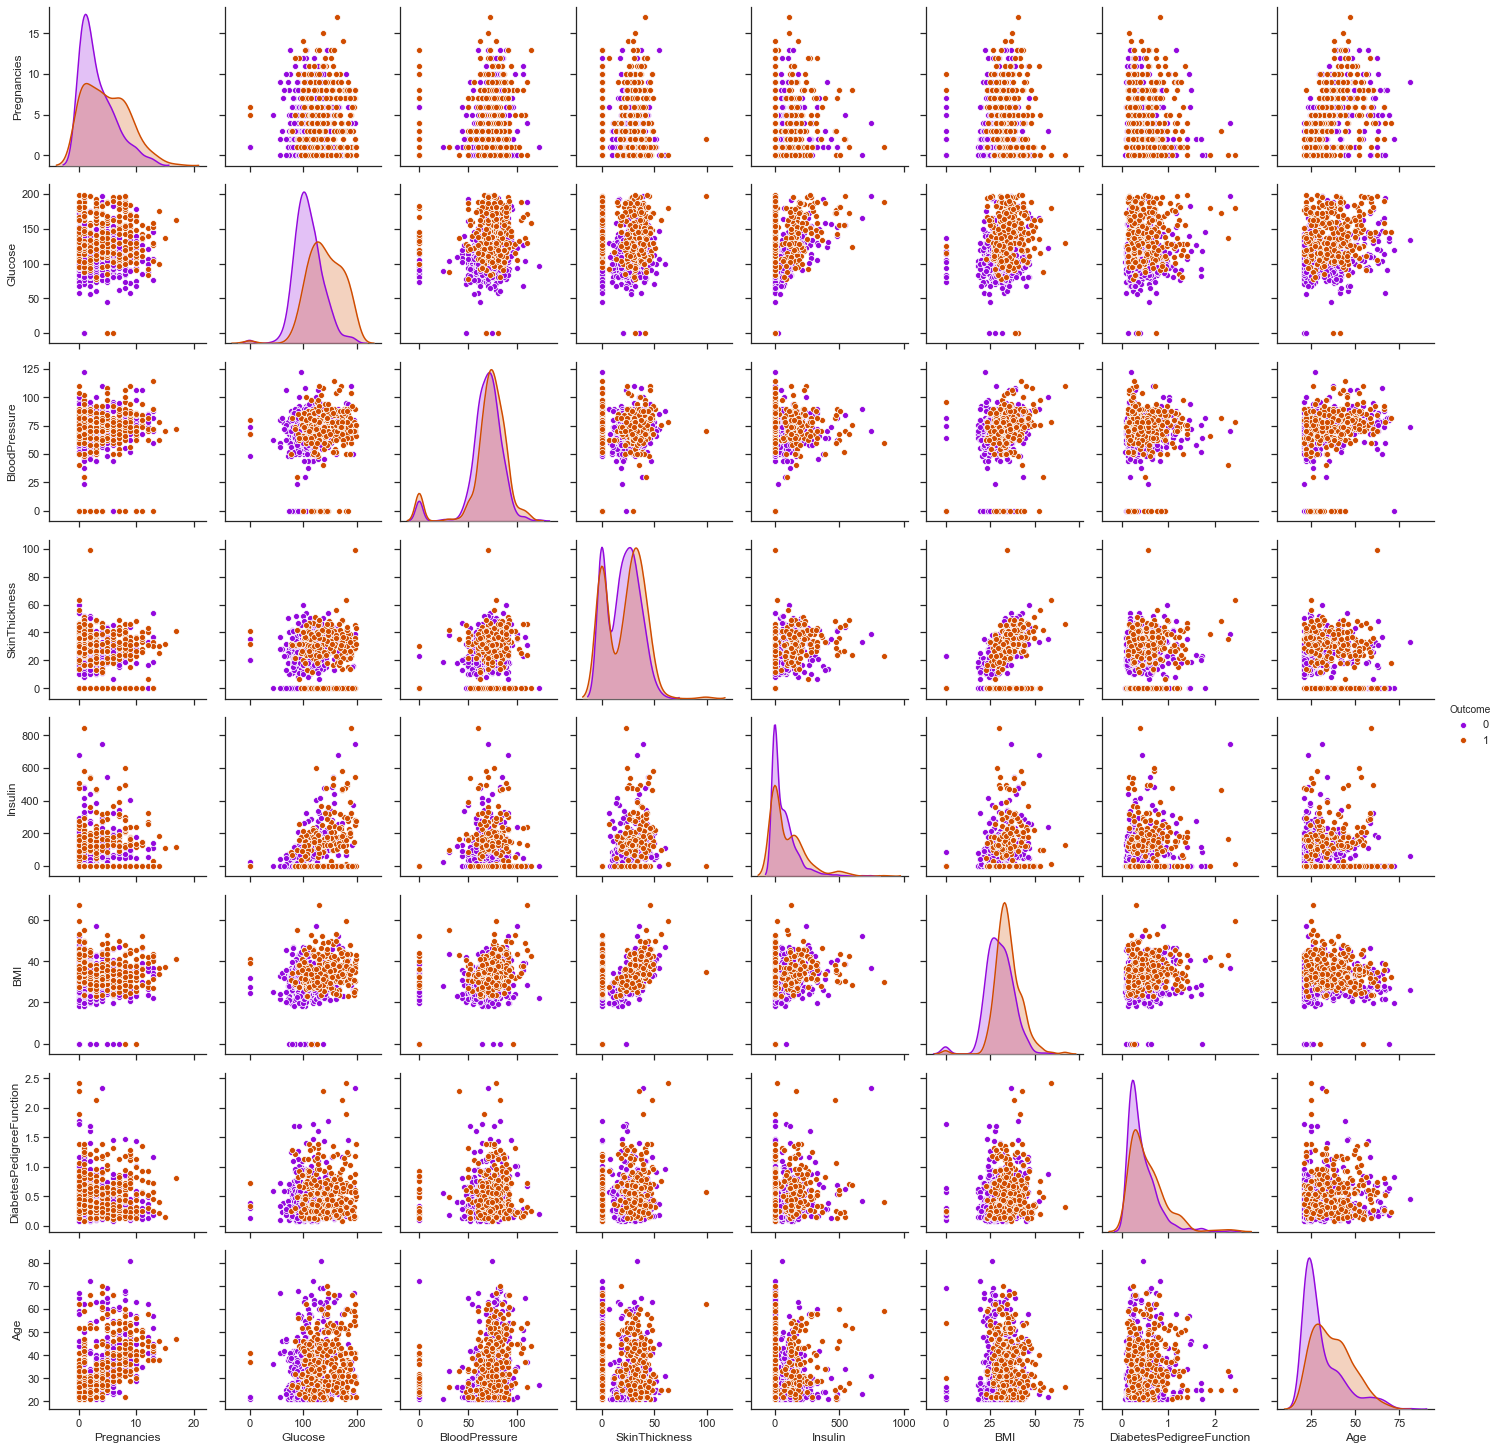

In [35]:
# Pairwise plot of all attributes 
sns.set(style="ticks", color_codes=True)
sns.pairplot(data,hue='Outcome',palette='gnuplot');

## Data processing 

In [36]:
# replacing missing value with nan value
nan_replacement_att=["Glucose",  "BloodPressure","SkinThickness","Insulin","BMI"]
data[nan_replacement_att]=data[nan_replacement_att].replace(0,np.nan)

median_target_all()  # median_target_all replaces nan value with median of that attribute grouped by outcome 

In [37]:
outliers_removal() # replacing outliers with Nan 

median_target_all()

In [38]:
print(data.isna().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


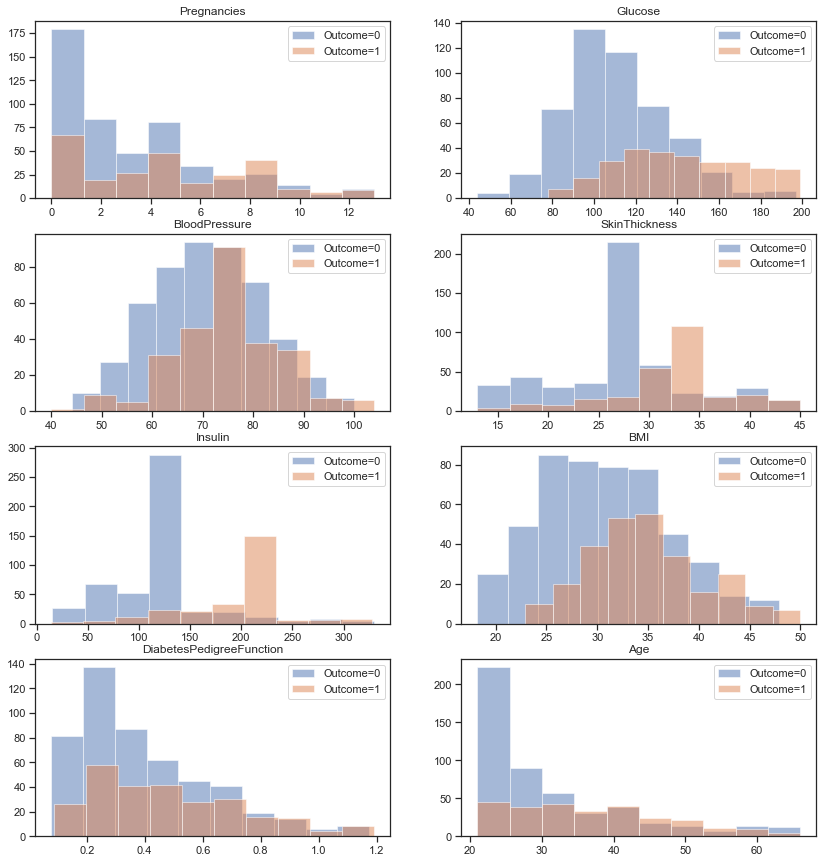

In [39]:
fig = plt.figure(figsize=(14,15))
fig.tight_layout(pad=3.0)
nrow,ncol,index=4,2,1    
for attribute in attributes:
    plt.subplot(nrow, ncol, index)
    plt.title(attribute)
    plt.hist(data[attribute][data.Outcome==0],alpha=0.5,label="Outcome=0")
    plt.hist(data[attribute][data.Outcome==1],alpha=0.5,label="Outcome=1")
    plt.legend(loc="best")
    index+=1
plt.show()


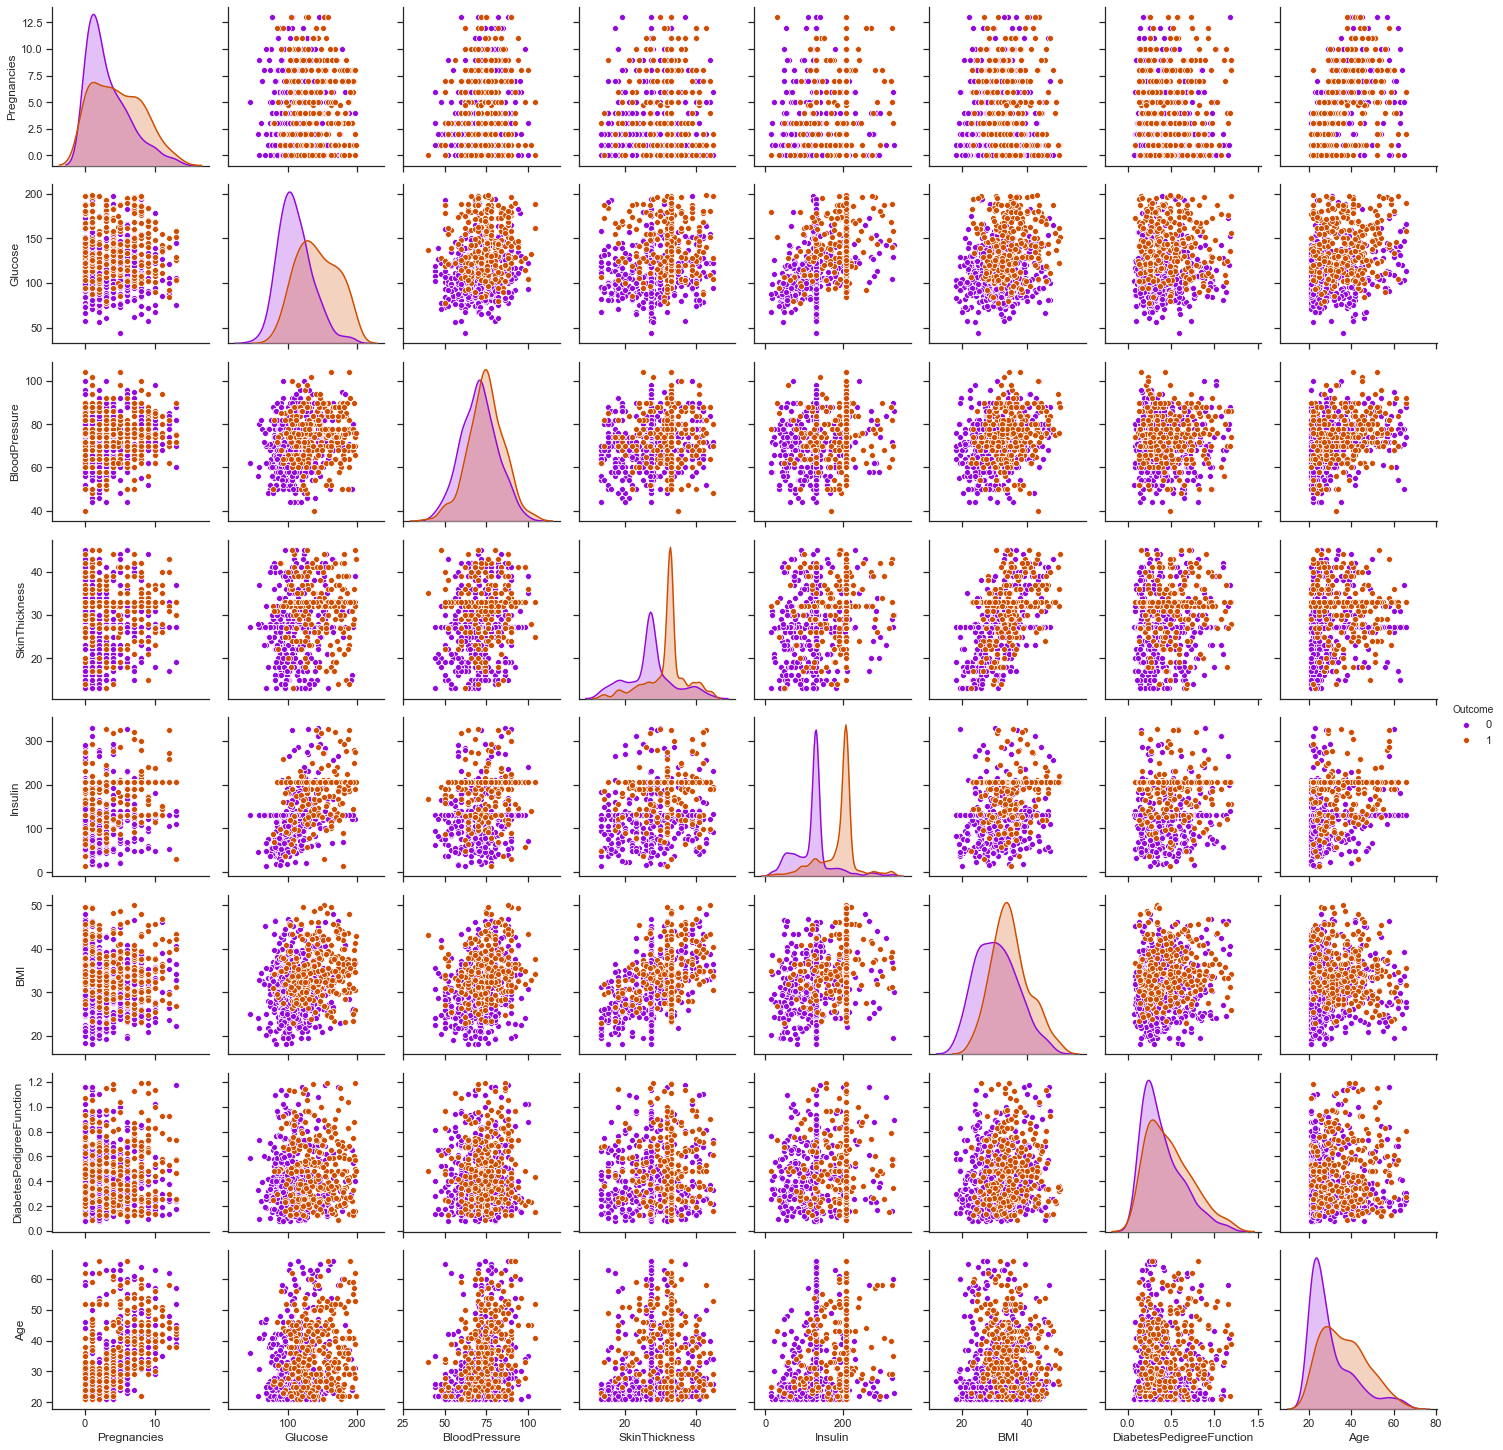

In [40]:

sns.set(style="ticks", color_codes=True)
sns.pairplot(data,hue='Outcome',palette='gnuplot');


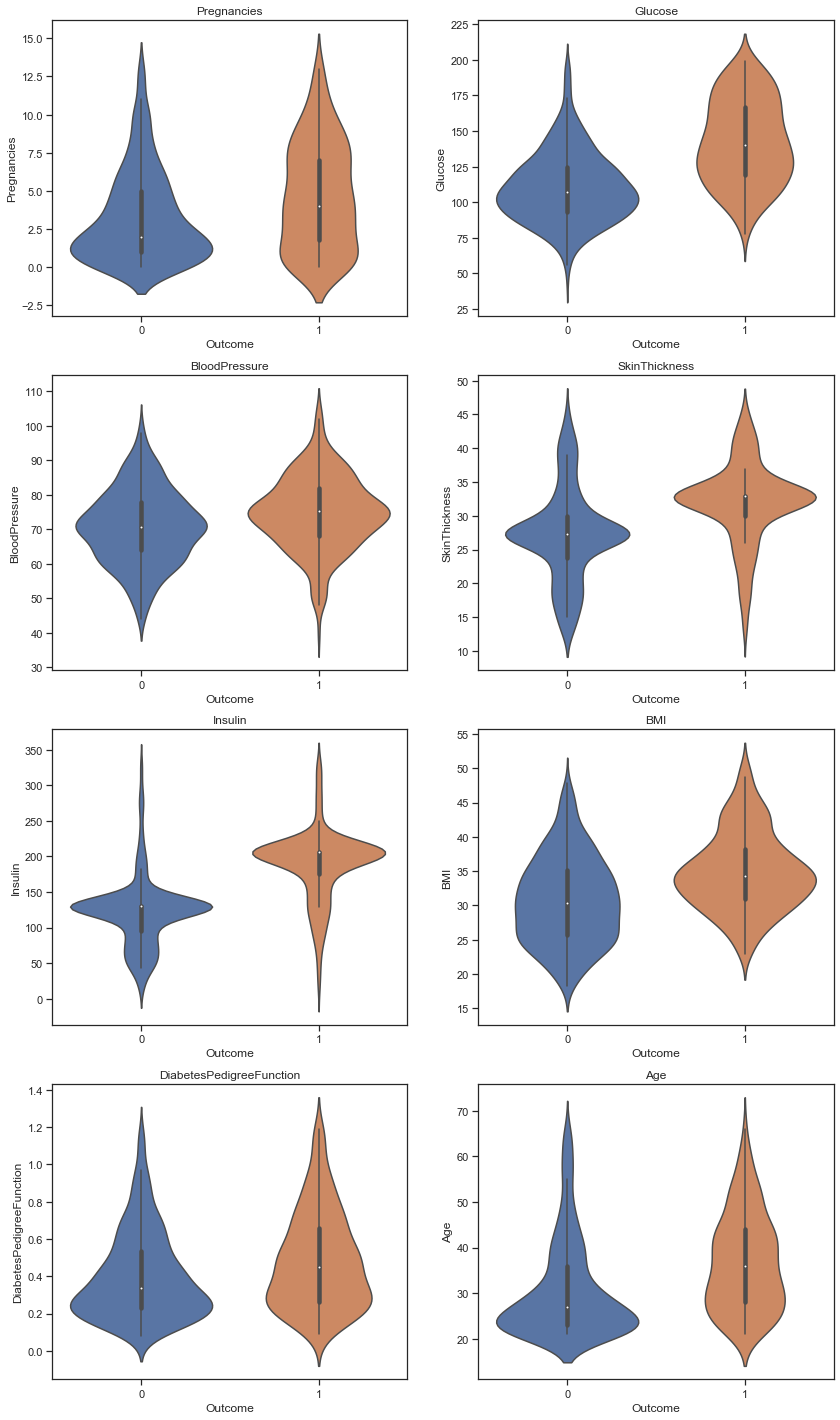

In [41]:
violin_plot()

In [42]:
# standardization of dataset
data_std=z_score(data)

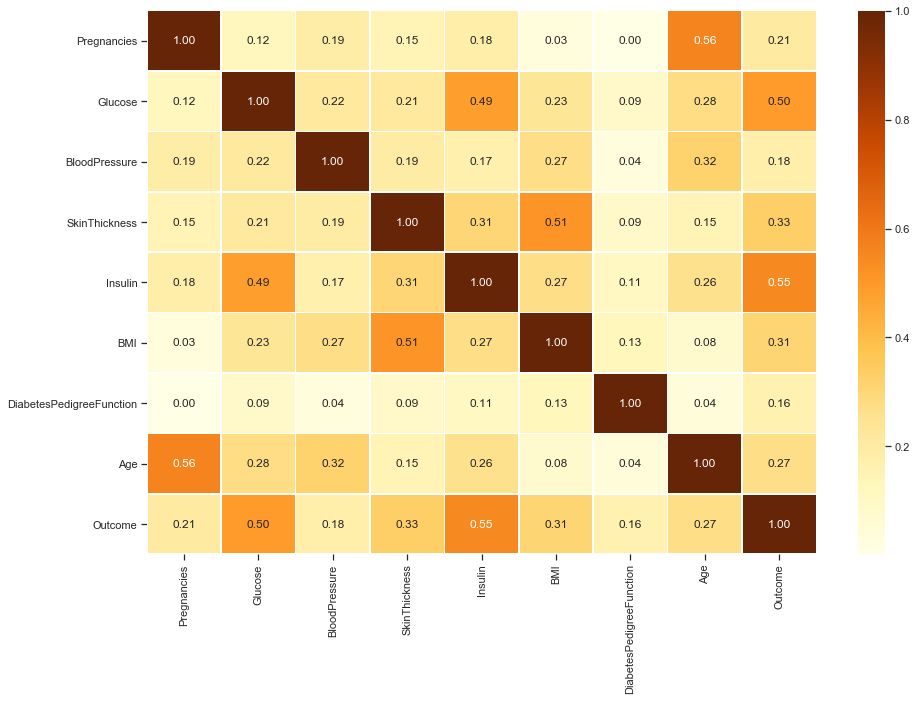

In [43]:
# It shows the correlation(positive,neagative) between different columns(only integer value columns) 
corr_matrix = data_std.corr()
fig,ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,annot=True,linewidth=0.5,fmt=".2f",cmap="YlOrBr")

###### Distribution of data set 

In [44]:
y = data["Outcome"]
X=data_std.drop("Outcome",axis=1)
X_train,X_test,y_train,y_test =  train_test_split(X,y,test_size=0.2)

## Models 

### Code using PCA for reducing dimensionality 
``` python 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
for i in range(1,9):

    list_of_algo=[LogisticRegression(),GaussianNB(),SVC(probability=True),KNeighborsClassifier(),
                  RandomForestClassifier(),AdaBoostClassifier(),XGBClassifier()]

    name_of_algo=["LogisticRegression","GaussianNB","SVM","KNeighborsClassifier",
                  "RandomForestClassifier","AdaBoostClassifier","XGBClassifier"]
    for i,algorithm in enumerate(list_of_algo):
        steps = [('pca', PCA(n_components=i)), ('m', algorithm)]
        model = Pipeline(steps=steps)

        #### Evaluate model
        model_score = cross_val_score(model, X, y, scoring='roc_auc',cv=10)
        print("*"*120)
        print('Accuracy of {} : {} '.format(name_of_algo[i],(model_score.mean()*100)))
    print(" ")
    print("#"*120)
    print("")
```


************************************************************************************************************************
AUC of LogisticRegression : 0.899 
AVG AUC of LogisticRegression : 89.086 + 0.028 
Precision of LogisticRegression : 75.862 
Recall of LogisticRegression : 81.481 


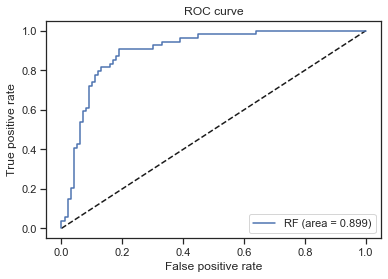

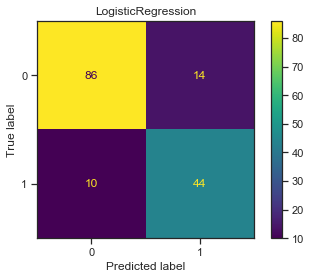

************************************************************************************************************************
AUC of GaussianNB : 0.887 
AVG AUC of GaussianNB : 88.609 + 0.029 
Precision of GaussianNB : 70.312 
Recall of GaussianNB : 83.333 


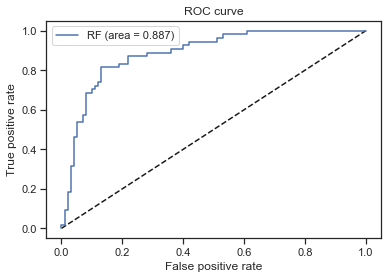

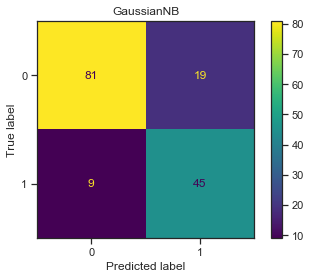

************************************************************************************************************************
AUC of SVM : 0.903 
AVG AUC of SVM : 87.846 + 0.048 
Precision of SVM : 77.586 
Recall of SVM : 83.333 


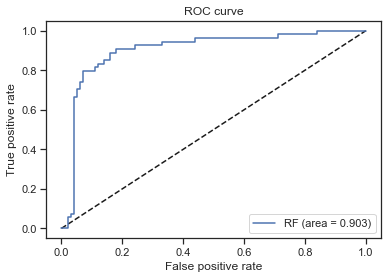

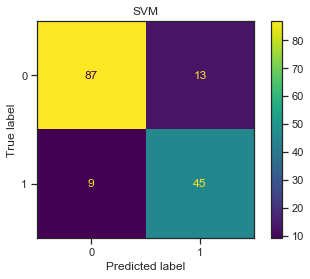

************************************************************************************************************************
AUC of KNeighborsClassifier : 0.914 
AVG AUC of KNeighborsClassifier : 90.406 + 0.047 
Precision of KNeighborsClassifier : 78.947 
Recall of KNeighborsClassifier : 83.333 


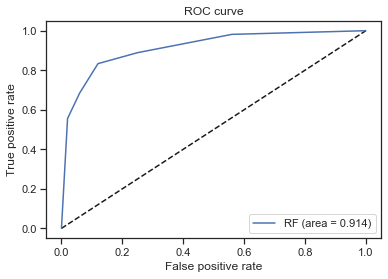

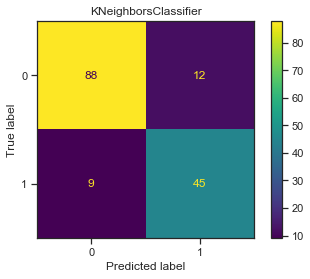

************************************************************************************************************************
AUC of RandomForestClassifier : 0.961 
AVG AUC of RandomForestClassifier : 94.751 + 0.021 
Precision of RandomForestClassifier : 85.714 
Recall of RandomForestClassifier : 88.889 


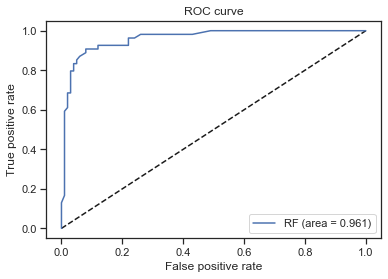

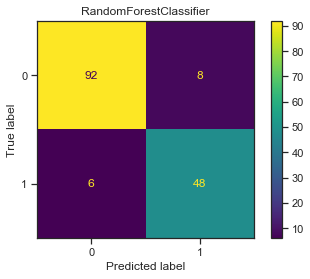

************************************************************************************************************************
AUC of AdaBoostClassifier : 0.937 
AVG AUC of AdaBoostClassifier : 94.648 + 0.023 
Precision of AdaBoostClassifier : 79.661 
Recall of AdaBoostClassifier : 87.037 


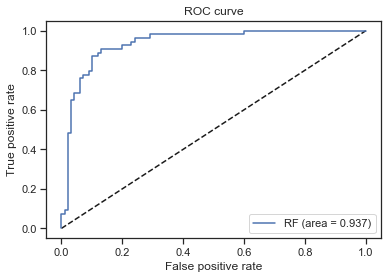

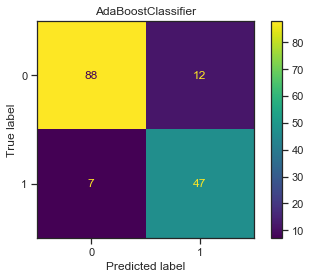

[00:17:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:17:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:17:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:17:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

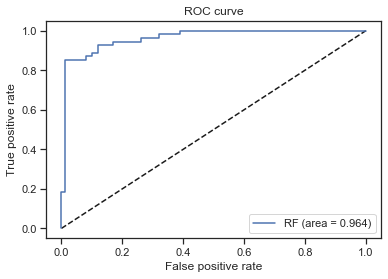

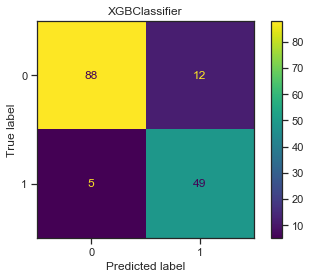

In [74]:
list_of_algo=[LogisticRegression(),GaussianNB(),SVC(probability=True),KNeighborsClassifier(),
              RandomForestClassifier(),AdaBoostClassifier(),XGBClassifier()]

name_of_algo=["LogisticRegression","GaussianNB","SVM","KNeighborsClassifier",
              "RandomForestClassifier","AdaBoostClassifier","XGBClassifier"]

for i,algorithm in enumerate(list_of_algo):
    model=algorithm
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    model_score=cross_val_score(model,X,y,cv=10,scoring="roc_auc")
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    auc_model = auc(fpr, tpr)
    print("*"*120)
    print('AUC of {} : {:.3f} '.format(name_of_algo[i],(auc_model)))
    print('AVG AUC of {} : {:.3f} + {:.3f} '.format(name_of_algo[i],(model_score.mean()*100),model_score.std()))
    print('Precision of {} : {:.3f} '.format(name_of_algo[i],(precision_score(y_test,y_pred)*100)))
    print('Recall of {} : {:.3f} '.format(name_of_algo[i],(recall_score(y_test,y_pred)*100)))
    plot_auc(fpr,tpr,auc_model)
    plot_confusion_matrix(model, X_test, y_test,values_format="d")
    plt.title(name_of_algo[i])
    plt.show()    

### Grid search for Random forest classifier
```python    
from sklearn.model_selection import GridSearchCV
print(RandomForestClassifier())
n_estimators = [100, 200, 250, 300, 350]
max_depth = [1, 3, 4, 5, 8, 10]
min_samples_split = [10, 15, 20, 25, 30, 100]
min_samples_leaf = [1, 2, 4, 5, 7] 
max_features = ['auto', 'sqrt']
criterion=['gini']
bootstrap = [True, False]
rfr=RandomForestClassifier()
hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,criterion=criterion,
              max_features = max_features,  min_samples_split = min_samples_split, 
              min_samples_leaf = min_samples_leaf,bootstrap = bootstrap)

gridF = GridSearchCV(rfr, hyperF,scoring='accuracy', cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)
```

### Grid search for XGB Classifer 
```python
from sklearn.model_selection import GridSearchCV
model = XGBClassifier()
param_grid = {
    'n_estimators': [100,200,300,],
    'colsample_bytree': [0.5,0.6,0.7],
    'max_depth': [3,5,8],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'subsample': [0.8, 0.9,1,1.1],
    'gamma':[1.4,1.5,1.6,]
}
gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=10, 
        n_jobs=-1, 
        scoring="roc_auc",
        verbose=2
    )
gsf=gs.fit(X_train,y_train)
print(gsf.best_params_)
```

## Finalizing optimal model for web application 

In [72]:
y = data["Outcome"]
X=data.drop(["Outcome"],axis=1)
X_train,X_test,y_train,y_test =  train_test_split(X,y,test_size=0.2)
model_opt = XGBClassifier(colsample_bytree = 0.5,max_depth = 8,n_estimators=100,
                          reg_alpha=1.1,reg_lambda=1.1, subsample=1,gamma=1.5)

model_opt.fit(X_train,y_train)
model_score=cross_val_score(model_opt,X,y,cv=10,scoring="roc_auc")

print(model_opt.score(X_test,y_test))
print("score {:.4f} + {:.4f}".format(model_score.mean(),model_score.std()))


[00:13:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:13:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:13:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:13:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

Epoch 1/200
77/77 [==============================] - 0s 2ms/step - loss: 0.9537 - accuracy: 0.5651
Epoch 2/200
77/77 [==============================] - 0s 3ms/step - loss: 0.7069 - accuracy: 0.6531
Epoch 3/200
77/77 [==============================] - 0s 4ms/step - loss: 0.6558 - accuracy: 0.6645
Epoch 4/200
77/77 [==============================] - 0s 4ms/step - loss: 0.6012 - accuracy: 0.7068
Epoch 5/200
77/77 [==============================] - 0s 2ms/step - loss: 0.6340 - accuracy: 0.7134
Epoch 6/200
77/77 [==============================] - 0s 2ms/step - loss: 0.5108 - accuracy: 0.7866
Epoch 7/200
77/77 [==============================] - 0s 2ms/step - loss: 0.5272 - accuracy: 0.7980
Epoch 8/200
77/77 [==============================] - 0s 3ms/step - loss: 0.4889 - accuracy: 0.7866
Epoch 9/200
77/77 [==============================] - 0s 3ms/step - loss: 0.4941 - accuracy: 0.8078
Epoch 10/200
77/77 [==============================] - 0s 2ms/step - loss: 0.4664 - accuracy: 0.8046
Epoch 11/

77/77 [==============================] - 0s 2ms/step - loss: 0.2972 - accuracy: 0.8893
Epoch 83/200
77/77 [==============================] - 0s 2ms/step - loss: 0.3034 - accuracy: 0.8746
Epoch 84/200
77/77 [==============================] - 0s 2ms/step - loss: 0.3164 - accuracy: 0.8713
Epoch 85/200
77/77 [==============================] - 0s 3ms/step - loss: 0.2858 - accuracy: 0.8941
Epoch 86/200
77/77 [==============================] - 0s 4ms/step - loss: 0.3336 - accuracy: 0.8779
Epoch 87/200
77/77 [==============================] - 0s 3ms/step - loss: 0.3325 - accuracy: 0.8713
Epoch 88/200
77/77 [==============================] - 0s 3ms/step - loss: 0.3038 - accuracy: 0.8811
Epoch 89/200
77/77 [==============================] - 0s 2ms/step - loss: 0.2939 - accuracy: 0.8893
Epoch 90/200
77/77 [==============================] - 0s 2ms/step - loss: 0.2886 - accuracy: 0.8827
Epoch 91/200
77/77 [==============================] - 0s 2ms/step - loss: 0.2927 - accuracy: 0.8876
Epoch 92/200


77/77 [==============================] - 0s 2ms/step - loss: 0.2357 - accuracy: 0.8974
Epoch 164/200
77/77 [==============================] - 0s 2ms/step - loss: 0.2082 - accuracy: 0.9186
Epoch 165/200
77/77 [==============================] - 0s 3ms/step - loss: 0.2086 - accuracy: 0.9104
Epoch 166/200
77/77 [==============================] - 0s 2ms/step - loss: 0.2384 - accuracy: 0.8958
Epoch 167/200
77/77 [==============================] - 0s 3ms/step - loss: 0.2356 - accuracy: 0.9137
Epoch 168/200
77/77 [==============================] - 0s 3ms/step - loss: 0.2100 - accuracy: 0.9088
Epoch 169/200
77/77 [==============================] - 0s 3ms/step - loss: 0.2108 - accuracy: 0.9055
Epoch 170/200
77/77 [==============================] - 0s 3ms/step - loss: 0.2233 - accuracy: 0.9088
Epoch 171/200
77/77 [==============================] - 0s 3ms/step - loss: 0.2226 - accuracy: 0.9121
Epoch 172/200
77/77 [==============================] - 0s 2ms/step - loss: 0.2170 - accuracy: 0.9088
Epoc

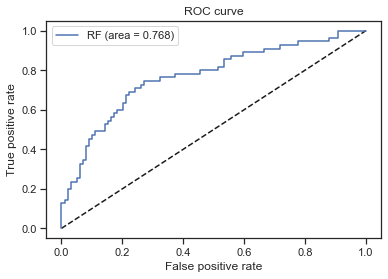

In [47]:

##Build an model(Neural model )
model = Sequential()
model.add(Dense(8, input_dim=8, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_fit=model.fit(X_train, y_train, epochs=200, batch_size=8)

_, nn_acc = model.evaluate(X_test, y_test)

y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_nn = auc(fpr, tpr)
plot_auc(fpr,tpr,auc_nn)



## Storing trained model in a file 

In [50]:
import pickle
# Save trained model to file
pickle.dump(model_opt, open("Diabetes.pkl", "wb"))
loaded_model = pickle.load(open("Diabetes.pkl", "rb"))
loaded_model.predict(X_test)
loaded_model.score(X_test,y_test)

0.8376623376623377